In [17]:
import torch
import matplotlib.pyplot as plt

In [18]:
vocab = {"closer": 0,
         "every": 1,
         "effort": 2,
         "forward": 3,
         "inches": 4,
         "moves": 5,
         "pizza": 6,
         "toward": 7,
         "you": 8
        }

inverse_vocab = {v:k for k,v in vocab.items()}

In [19]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.9, 6.75, 1.63, -1.62, -1.89, 6.29, 1.79]
)

probs = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probs).item()
print(inverse_vocab[next_token_id])

forward


In [4]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probs, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [5]:
def print_sampled_tokens(probs):
    torch.manual_seed(123)
    sample = [torch.multinomial(probs, num_samples=1).item() for _ in range(1000)]

    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probs)

71 x closer
0 x every
0 x effort
579 x forward
2 x inches
0 x moves
0 x pizza
348 x toward


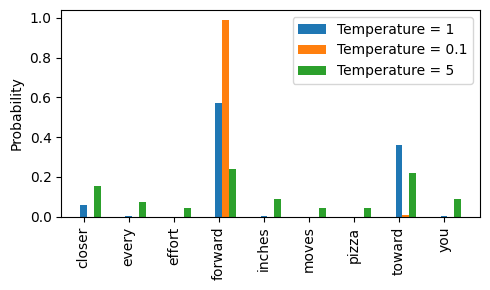

In [6]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]
scaled_probs = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i*bar_width, scaled_probs[i], bar_width, label=f"Temperature = {T}")

ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [7]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print(top_logits)
print(top_pos)

tensor([6.7500, 6.2900, 4.5100])
tensor([3, 7, 0])


In [13]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(-torch.inf),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2900,   -inf])


In [14]:
topk_probs = torch.softmax(new_logits, dim=0)
print(topk_probs)

tensor([0.0613, 0.0000, 0.0000, 0.5755, 0.0000, 0.0000, 0.0000, 0.3633, 0.0000])


In [28]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, 
                                 torch.tensor(-torch.inf).to(logits.device), 
                                 logits)

        if temperature > 0.0:
            logits /= temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        if idx_next == eos_id:
            break

        idx = torch.cat([idx, idx_next], dim=-1)
    return idx

In [29]:
from codes.gpt_model import GPTModel
from codes.configs import GPT_CONFIG_124M
from codes.utils import text_to_token_ids, token_ids_to_text
import tiktoken

In [30]:
model = GPTModel(GPT_CONFIG_124M)
pretrained_pth = "./model_and_optimizer.pth"
state_dict = torch.load(pretrained_pth, map_location="cpu")["model_state_dict"]

model.load_state_dict(state_dict)

<All keys matched successfully>

In [34]:
torch.manual_seed(123)
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate(
    model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=0.8
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you had always The mere-stream stroke. Gisburn--as such--
